Original paper: https://arxiv.org/abs/1806.00035

# 0. Read real and generated images#

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

In [0]:
CHANNEL_NUM = 3
PICTURE_SIZE = 36

In [0]:
class ParticleDataset():
    def __init__(self, file):
        self.data = np.load(file)
        self.image = self.data['Pictures'].reshape(-1, CHANNEL_NUM*PICTURE_SIZE*PICTURE_SIZE)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, i):
        return {
            "Pictures": self.image[i],
        }

In [0]:
real_data = ParticleDataset('real.npz')
vae_data = ParticleDataset('vae.npz')
gan_data = ParticleDataset('gan.npz')

Make sure that the values of real and generated data are of the same order - it is important for cooperative binarizing

In [34]:
print (np.min(real_data.image), np.max(real_data.image))
print (np.min(gan_data.image), np.max(gan_data.image))
print (np.min(vae_data.image), np.max(vae_data.image))

0.0 1.0
0.0 1.0
0.12434786 0.86325157


# 1. Binarize# 

To understand how real and generated objects are close to each other, we need to choose a space of features in which we look these objects at

We go the easiest way and take pixels' values as features.

In [0]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import sklearn.preprocessing
import math
## function which map object to probability distribution ##

def bin_counts (real_data, generated_data, number_of_bins=25):
    # binirize real and generated data, plot histogram and found density function
    
    #from article git

    data = np.vstack([real_data, generated_data])
  
    kmeans = MiniBatchKMeans(n_clusters= number_of_bins, n_init=10)
  
    labels = kmeans.fit(data).labels_
  
    real_density, _ = np.histogram(labels[:len(real_data)], bins=number_of_bins,
                               range=[0, number_of_bins], density=True)
    
    gen_density, _ = np.histogram(labels[len(real_data):], bins=number_of_bins,
                                   range=[0, number_of_bins], density=True)
    
   
    plt.figure()
    plt.hist(real_data.flatten(), bins=number_of_bins, density=True)
    plt.title('real_data')
    plt.show()
    
    plt.figure()
    plt.hist(generated_data.flatten(), bins=number_of_bins, density=True)
    plt.title('generated_data')
    plt.show()
    
   
    return real_density, gen_density







Create $\alpha-$ and $\beta-$ vectors as in

$\hat{PRD}(Q,P) = \{(\alpha(\lambda), \beta(\lambda))| \lambda \in \Lambda \}$, where $\Lambda = \{\tan (\frac{i}{m+1} \frac{\pi}{2}) | i = 1, 2 ... m\}$

In [0]:
def count_alpha_beta (real_density, gen_density, num_angles = 1000):
    assert real_density.shape == gen_density.shape
    alpha_vec = []
    beta_vec = []
    angles = np.linspace(1e-6, np.pi/2 - 1e-6, num=num_angles)
    # you code
    for i in range(len(angles)):
      
      element = np.tan(angles[i]) * real_density
      al1 = np.minimum( element, gen_density)
      al = np.sum(al1)
      alpha_vec.append(  al  )
      
     
      beta_vec.append(  np.sum(np.minimum(real_density, gen_density/np.tan(angles[i]) ) )   )

    return alpha_vec, beta_vec

For stability, take the average of several repetitions

In [0]:
def count_prd(reals, gens, repeat_number = 10):
    vectors = [count_alpha_beta(reals, gens) for i in range(repeat_number)]
    vectors = np.array(vectors).mean(axis=0)
    print (vectors.shape)
    return vectors

## 2. Apply it##

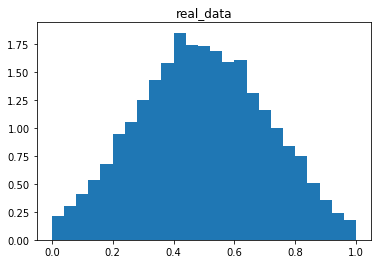

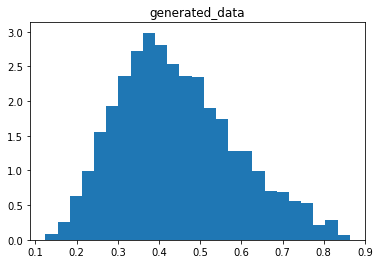

In [298]:
a, b = bin_counts(real_data.image, vae_data.image)

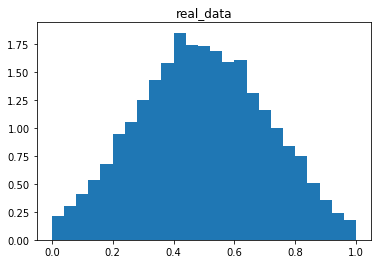

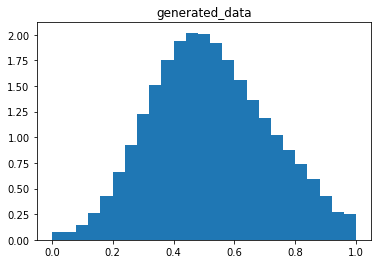

In [299]:
c, d = bin_counts(real_data.image, gan_data.image)

## 3. Make vectors for plot and plot ##

In [300]:
data_for_plots = count_prd(a, b)
data_for_plots2 = count_prd(c, d)

(2, 1000)
(2, 1000)


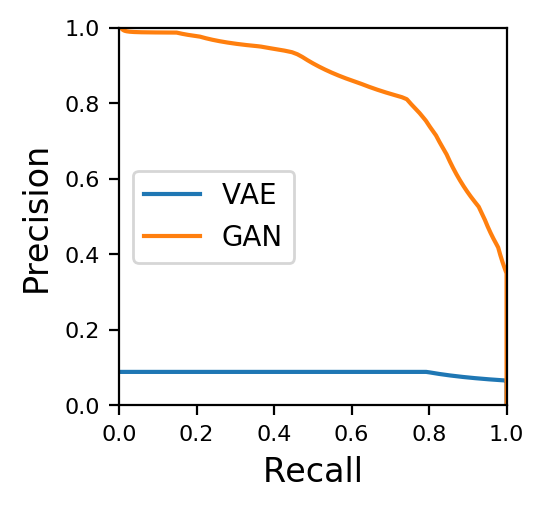

In [301]:
fig = plt.figure(figsize=(2.5, 2.5), dpi=200)
fig.add_subplot(111).tick_params(axis='both', which='major', labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.plot(data_for_plots[0], data_for_plots[1], label = "VAE")
plt.plot(data_for_plots2[0], data_for_plots2[1], label = "GAN")
plt.legend()
plt.show()

**What curves were obtained for the first(VAE) and the second(GAN) models? What can we say about the advantages and disadvantages of each model?**

i can only say that my implementation of VAE model is bad, because of that i think that comparison will be not representative


## Bonus: about features' space##

It is possible to transfer the picture-> embedding, for example, using the 1st part of the Inception network as a feature extraxtor. This embedding can be used for bin counts also

In [0]:
# if you came here and still alive, the implementation of idea above will give you extra points =)
